In [3]:
import sys
# sys.path.append("../SpikeCounter")
import numpy as np
import skimage.io as skio
import scipy.ndimage as ndi
import scipy.signal as signal
import scipy.stats as stats
import scipy.fft as fft
from skimage.measure import label
import matplotlib.pyplot as plt
from tifffile import imsave
import scipy.ndimage as ndimage
import matplotlib.colors as colors
import matplotlib.patches as patches
import colorcet as cc
from cycler import cycler
import os
from scipy import interpolate, optimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import mat73
import pandas as pd
import parse
from spikecounter.analysis import traces, images
from spikecounter.ui import visualize, HyperStackViewer
from spikecounter import utils
from skimage import draw, morphology, transform, filters

# plt.style.use("../bio_pubs_presentation.mplstyle")
ss = StandardScaler()

In [ ]:
rootdir = "F:/Bill Jia/Optopatch/20220306/"
# rootdir = "/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing"
filename = "133111E4_target4_50Hz"
crosstalk_channel = "None"

## Fast STA

In [408]:
def generate_invalid_frame_indices(stim_trace, dt_frame):
    invalid_indices_daq = np.argwhere(stim_trace > 0).ravel()
    if np.sum(np.diff(invalid_indices_daq)<2) == 0:
        invalid_indices_camera = np.unique(np.concatenate((invalid_indices_daq, invalid_indices_daq+1)))
    else:
        invalid_indices_camera = invalid_indices_daq
    return invalid_indices_camera

In [409]:
crosstalk_channel = "enable488"

In [410]:
img, expt_data = images.load_image(rootdir, filename, raw=True)
trace_dict, dt_frame = utils.traces_to_dict(expt_data)
fs = 1/dt_frame

In [411]:
invalid_indices = generate_invalid_frame_indices(trace_dict[crosstalk_channel], dt_frame)


In [412]:
factor = 4
downsampled = transform.downscale_local_mean(img, (1,factor,factor))
# img = img[:,::factor,:]
# img = img[:,:,::factor]

In [413]:
target_img_space = expt_data["dmd_lightcrafter"]['target_image_space']
# plt.imshow(target_img_space)
target_img_space = target_img_space[::factor,::factor]
offset = [(target_img_space.shape[0]-downsampled.shape[1])//2, (target_img_space.shape[1]-downsampled.shape[2])//2]
target_img_space = target_img_space[offset[0]:-offset[0],offset[1]:-offset[1]]
target_img_space = target_img_space.astype(bool)

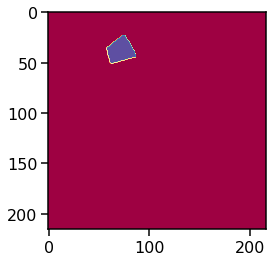

In [414]:
plt.imshow(target_img_space)

(array([2152., 6386., 7217., 6189., 7770., 7970., 4408., 3356., 1157.,
          51.]),
 array([131.40702083, 142.94171458, 154.47640833, 166.01110208,
        177.54579583, 189.08048958, 200.61518333, 212.14987708,
        223.68457083, 235.21926458, 246.75395833]),
 <BarContainer object of 10 artists>)

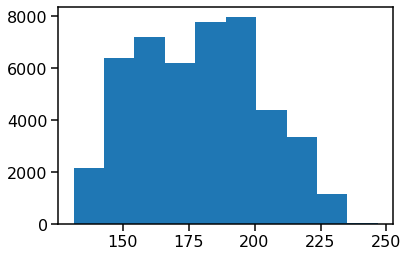

In [415]:
mean_img = downsampled.mean(axis=0)
plt.hist(mean_img.ravel())

In [416]:
# invalid_mask = np.zeros(img.shape[0], dtype=bool)
# invalid_indices = invalid_indices[invalid_indices < img.shape[0]]
# invalid_mask[invalid_indices] = True
# stim_frames_removed = images.interpolate_invalid_values(img, invalid_mask)

In [417]:
nsamps = (int(2*fs)//2)*2 +1
pb_corrected_img = images.correct_photobleach(downsampled, mask=None, method="localmin", nsamps=nsamps)


(3000, 216, 216)


In [418]:
dFF = images.get_image_dFF(pb_corrected_img)

In [419]:
target_trace = images.image_to_trace(dFF, mask=target_img_space)

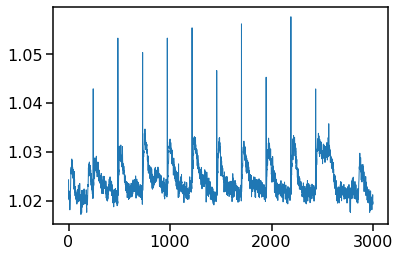

In [420]:
plt.plot(target_trace)

In [421]:
sta = images.spike_triggered_average_video(dFF, invalid_indices+1,0,200)

In [422]:
target_sta = images.image_to_trace(sta, mask=target_img_space)

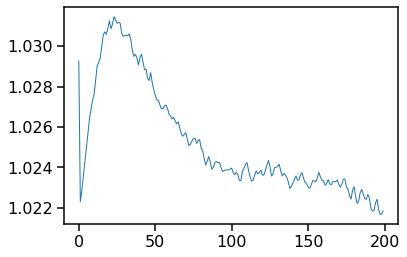

In [423]:
plt.plot(target_sta)

In [424]:
skio.imsave(os.path.join(output_folder, "%s_sta.tif" % filename), sta)

C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\3942651040.py:1: UserWarning: F:/Bill Jia/Optopatch/20220306/132933E4_target3_50Hz_sta.tif is a low contrast image
  skio.imsave(os.path.join(output_folder, "%s_sta.tif" % filename), sta)


## Convert to tif, downsample and denoise

In [425]:
rootdir = "F:/Bill Jia/Optopatch/20220306/"
# rootdir = "/n/holyscratch01/cohen_lab/bjia/20220301_gtacr_targeted_silencing"
filename = "134239gtacr_E7_endogenous_50Hz"
crosstalk_channel = "None"

In [454]:
img, expt_data = images.load_image(rootdir, filename, raw=True)

In [455]:
scale_factor = 8
output_folder = rootdir
n_pcs = 30
remove_from_start = 200
remove_from_end = 0
skewness_threshold = 0
left_shoulder = 16
right_shoulder = 19
trace_dict, dt_frame = utils.traces_to_dict(expt_data)
fs = 1/dt_frame

In [456]:
os.makedirs(os.path.join(output_folder, "denoised"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "downsampled"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "stim_frames_removed"), exist_ok=True)
os.makedirs(os.path.join(output_folder, "corrected"), exist_ok=True)

In [457]:
trimmed = img[remove_from_start:img.shape[0]-remove_from_end]
downsampled = transform.downscale_local_mean(trimmed, (1,scale_factor,scale_factor))
# skio.imsave(os.path.join(output_folder, "downsampled", "%s.tif" % expt_name), np.round(downsampled).astype(np.uint16))


In [458]:
nsamps = (int(2*fs)//2)*2 +1
pb_corrected_img = images.correct_photobleach(downsampled, mask=None, method="localmin", nsamps=nsamps)
# skio.imsave(os.path.join(output_folder, "corrected", "%s.tif" % expt_name), pb_corrected_img)

(1260, 108, 108)


In [459]:
mean_img = pb_corrected_img.mean(axis=0)

# Zero the mean over time
t_zeroed = pb_corrected_img - mean_img
data_matrix = t_zeroed.reshape((t_zeroed.shape[0], -1))

# bandpass to get rid of BU noise
if left_shoulder < fs/2:
    if right_shoulder == -1:
        sos = signal.butter(5,[left_shoulder], output="sos", fs=fs)
    else:
        sos = signal.butter(5,[left_shoulder,right_shoulder], btype="bandstop", output="sos", fs=fs)
    data_matrix_filtered = np.apply_along_axis(lambda x: signal.sosfiltfilt(sos, x), 0, data_matrix)
else:
    data_matrix_filtered = data_matrix

# SVD
denoised = images.denoise_svd(data_matrix_filtered, n_pcs, skewness_threshold=skewness_threshold)
denoised = denoised.reshape(downsampled.shape)
# u, s, v = randomized_svd(data_matrix_filtered, n_components=60)

# use_pcs = np.zeros_like(s,dtype=bool)
# use_pcs[:n_pcs] = True
# if args.filter_skewness:
#     skw = np.apply_along_axis(lambda x: stats.skew(np.abs(x)), 1, v)
#     use_pcs = use_pcs & (skw > args.skewness_threshold)
    

# denoised = u[:,use_pcs]@ np.diag(s[use_pcs]) @ v[use_pcs,:]
# denoised = denoised.reshape(pb_corrected_img.shape)

# Add back DC offset for the purposes of comparing noise to mean intensity
denoised += mean_img
skio.imsave(os.path.join(output_folder, "denoised", "%s.tif" % filename), denoised.astype(np.float32))


## Load image

In [460]:
def image_to_sta(raw_img, fs=1, mask=None, plot=False, \
                 savedir=None, prom_pct=90, sta_bounds="auto", \
                 exclude_pks = None, offset=0, full_output=False):
    """ Convert raw image into spike triggered average
    """
    if savedir is not None:
        os.makedirs(savedir, exist_ok=True)

    if plot:
        fig1, axes = plt.subplots(2,2, figsize=(10,10))
        axes = axes.ravel()

    # Generate mask if not provided
    mean_img = raw_img.mean(axis=0)
    if mask is None:
        mask = mean_img > np.percentile(mean_img, 80)
        kernel_size = int(mask.shape[0]/50)
        mask = morphology.binary_closing(mask, selem=np.ones((kernel_size, kernel_size)))
    _ = visualize.display_roi_overlay(mean_img, mask.astype(int), ax=axes[0])
    
    raw_trace = images.image_to_trace(raw_img, np.tile(mask, (raw_img.shape[0], 1, 1)))
    
    # convert to DF/F
    
    dFF_img = images.get_image_dFF(raw_img)
    
    if savedir:
        skio.imsave(os.path.join(savedir, "dFF.tif"), dFF_img)

    dFF_mean = images.image_to_trace(dFF_img, mask=np.tile(mask, (dFF_img.shape[0], 1, 1)))

    # Identify spikes
    ps = np.percentile(dFF_mean,[10,prom_pct])
    prominence = ps[1] - ps[0]
    pks, _ = signal.find_peaks(dFF_mean, prominence=prominence)
    
    if exclude_pks:
        keep = np.ones(len(pks))
        keep[exclude_pks] = 0
        pks = pks[keep]

    if plot:
        axes[1].plot(np.arange(dFF_img.shape[0])/fs, dFF_mean)
        axes[1].plot(pks/fs, dFF_mean[pks], "rx")
        axes[1].set_xlabel("Time (s)")
        axes[1].set_ylabel(r"$F/F_0$")
        tx = axes[1].twinx()
        tx.plot(np.arange(dFF_img.shape[0])/fs, raw_trace, color="C1")
        tx.set_ylabel("Mean counts")

    # Automatically determine bounds for spike-triggered average
    if sta_bounds == "auto":
        try:
        # Align all detected peaks of the full trace and take the mean
            aligned_traces = traces.align_fixed_offset(np.tile(dFF_mean, (len(pks), 1)), pks)
        except Exception as e:
            print(e)
            return raw_trace
        mean_trace = np.nanmean(aligned_traces, axis=0)
        # Smooth
        spl = interpolate.UnivariateSpline(np.arange(len(mean_trace)), \
                                np.nan_to_num(mean_trace, nan=np.nanmin(mean_trace)), s=0.001)
        smoothed = spl(np.arange(len(mean_trace)))
        smoothed_dfdt = spl.derivative()(np.arange(len(mean_trace)))   
        # Find the first minimum before and the first minimum after the real spike-triggered peak
        if plot:
            axes[3].plot(mean_trace)
            axes[3].plot(smoothed, color="C1")
            tx = axes[3].twinx()
            tx.plot(smoothed_dfdt, color="C2")
            tx.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        try:
            minima_left = np.argwhere((smoothed_dfdt < 0)).ravel()
            minima_right = np.argwhere((smoothed_dfdt > 0)).ravel()
            # calculate number of samples to take before and after the peak
            b1 = pks[-1] - minima_left[minima_left<pks[-1]][-1]+offset
            b2 = minima_right[minima_right > pks[-1]][0] - pks[-1]+offset
        except Exception:
            return mean_trace
        
        if plot:
            axes[3].plot([pks[-1]-b1, pks[-1], pks[-1]+b2], mean_trace[[pks[-1]-b1, pks[-1], pks[-1]+b2]], "rx")
    else:
        b1,b2 = sta_bounds


    # Collect spike traces according to bounds
    spike_traces = np.nan*np.ones((len(pks), b1+b2))
    spike_images = np.nan*np.ones((len(pks), b1+b2, dFF_img.shape[1], dFF_img.shape[2]))
    print(b1,b2)
    for idx, pk in enumerate(pks):
        n_prepend = max(0, b1-pk)
        n_append = max(0, pk+b2-len(dFF_mean))

        mean_block = np.concatenate([np.ones(n_prepend)*np.nan, dFF_mean[max(0, pk-b1):min(len(dFF_mean), pk+b2)], np.ones(n_append)*np.nan])
        img_block = np.concatenate([np.ones((n_prepend, dFF_img.shape[1], dFF_img.shape[2]))*np.nan, \
                                    dFF_img[max(0, pk-b1):min(len(dFF_mean), pk+b2),:,:], np.ones((n_append, dFF_img.shape[1], dFF_img.shape[2]))*np.nan])
        
        spike_traces[idx,:] = mean_block
        spike_images[idx,:,:] = img_block
    
    sta_trace = np.nanmean(spike_traces, axis=0)
    sta = np.nanmean(spike_images, axis=0)

    if plot:
        axes[2].plot(np.arange(b1+b2)/fs, sta_trace)
        axes[2].set_xlabel("Time (s)")
        axes[2].set_ylabel(r"$F/F_0$")
        axes[2].set_title("STA taps: %d + %d" % (b1,b2))
        plt.tight_layout()
    if savedir:
        skio.imsave(os.path.join(savedir, "sta.tif"), sta)
        if plot:
            plt.savefig(os.path.join(savedir, "QA_plots.tif"))
    if full_output:
        return sta, spike_images
    return sta

In [461]:
print(filename)
# img, expt_data = images.load_image(rootdir, filename, subfolder="denoised")
img = images.correct_photobleach(denoised, method="linear")
print(img.shape)

134239gtacr_E7_endogenous_50Hz
(1260, 108, 108)


In [462]:
dt_dict, dt = utils.traces_to_dict(expt_data)

In [465]:
center_mask = np.zeros((img.shape[1], img.shape[2]), dtype=bool)
center_mask[40:60,40:50] = True
# center_mask = None

C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\4271719458.py:28: UserWarning: F:/Bill Jia/Optopatch/20220306/analysis\134239gtacr_E7_endogenous_50Hz\dFF.tif is a low contrast image
  skio.imsave(os.path.join(savedir, "dFF.tif"), dFF_img)
C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


60 45


C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\4271719458.py:112: UserWarning: F:/Bill Jia/Optopatch/20220306/analysis\134239gtacr_E7_endogenous_50Hz\sta.tif is a low contrast image
  skio.imsave(os.path.join(savedir, "sta.tif"), sta)


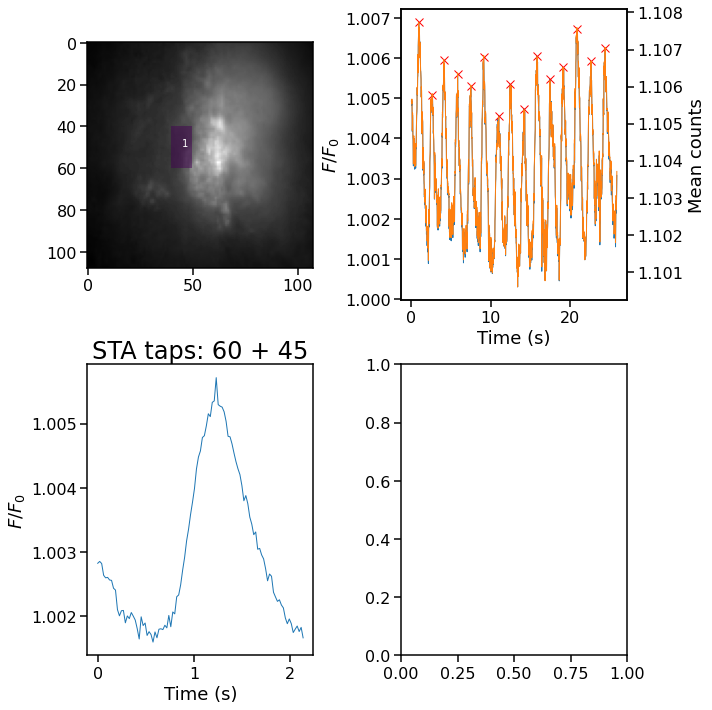

In [466]:
sta, spike_images = image_to_sta(img, fs=1/dt, plot=True, prom_pct=80, sta_bounds=(60,45),\
                   savedir=os.path.join(rootdir, "analysis", filename), offset=200, full_output=True, mask=center_mask)

In [467]:
utils.display_zstack(sta[:,:,:, np.newaxis], c=0, pct_cutoffs=[5,99])

interactive(children=(IntSlider(value=52, description='z', max=104), Dropdown(description='c', options=('all',…

In [468]:
beta, smoothed_vid = images.spline_timing(sta, s=0.05, n_knots=15)

C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = asanyarray(func1d(inarr_view[ind0], *args, **kwargs))
C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\shape_base.py:402: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


In [469]:
os.makedirs(os.path.join(rootdir, "analysis", filename, "individual_spikes"), exist_ok=True)
skio.imsave(os.path.join(rootdir, "analysis", filename, "spline_smoothed_vid.tif"), smoothed_vid)
np.savez(os.path.join(rootdir, "analysis", "%s_snapt_denoised.npz") % filename,\
         beta=beta)

C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\1334898136.py:2: UserWarning: F:/Bill Jia/Optopatch/20220306/analysis\134239gtacr_E7_endogenous_50Hz\spline_smoothed_vid.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", filename, "spline_smoothed_vid.tif"), smoothed_vid)


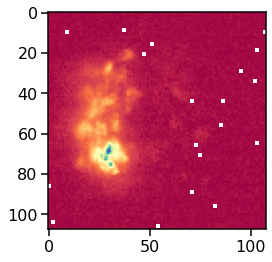

In [470]:
amplitude = beta[2,:,:]
plt.imshow(amplitude)

In [471]:
amplitude_2048 = np.zeros((2048, 2048))
amplitude_rescaled = transform.rescale(beta[2,:,:], factor)
offset = [(2048 - amplitude_rescaled.shape[0])//2, \
          (2048 - amplitude_rescaled.shape[1])//2]
amplitude_2048[offset[0]:-offset[0],offset[1]:-offset[1]] = amplitude_rescaled-1

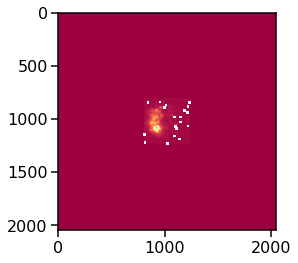

In [472]:
plt.imshow(amplitude_2048)

In [473]:
skio.imsave(os.path.join(rootdir, "Snaps", "%s_spike_amplitude.tiff" % filename), amplitude_2048)

C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_opening`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)
C:\Users\labmember\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_closing`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


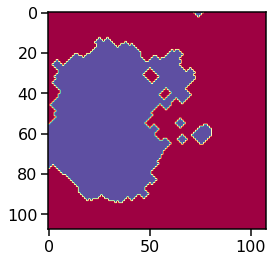

In [474]:
amplitude = beta[2,:,:]
amplitude_nanr = np.copy(amplitude)
minval = np.nanmin(amplitude)
amplitude_nanr[np.isnan(amplitude)] = minval
thresh = np.percentile(amplitude_nanr,40)
# thresh = filters.threshold_otsu(amplitude_nanr)
mask = amplitude_nanr>thresh
mask = morphology.binary_opening(mask, selem=morphology.disk(2))
mask = morphology.binary_closing(mask, selem=morphology.disk(2))
plt.imshow(mask)

In [475]:
hm = beta[1,:,:]
average_regional_nans = ndimage.convolve(np.isnan(hm), np.ones((3,3)))
convinput = np.copy(hm)
convinput[np.isnan(hm)] = 0
kernel = np.ones((3,3))
kernel[1,1] = 0
hm_nans_removed = np.copy(hm)
hm_nans_removed[np.isnan(hm)] = ndimage.convolve(convinput,kernel)[np.isnan(hm)]

In [476]:
hm_smoothed = ndimage.median_filter(hm_nans_removed, size=3)
hm_smoothed = ndimage.gaussian_filter(hm_smoothed, sigma=1)
hm_nan = np.copy(hm_smoothed)
hm_nan[~mask] = np.nan
hm_nan = (hm_nan-np.nanmin(hm_nan))*dt*1000

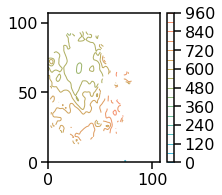

In [477]:
fig1, ax1 = plt.subplots(figsize=(2.5,2.75))

im = ax1.contour(hm_nan, vmin=np.percentile(hm_nan[~np.isnan(hm_nan)],0), \
               vmax=np.percentile(hm_nan[~np.isnan(hm_nan)],99), levels=16, \
                 cmap = plt.get_cmap("cet_CET_I1"))
plt.colorbar(im)

In [478]:
pmin, pmax = np.percentile(hm_nan[~np.isnan(hm_nan)],[0.5, 95])
sigma = 1
hm_time_smoothed = np.copy(hm_nan)
hm_time_smoothed[np.isnan(hm_time_smoothed)] = pmax
hm_time_smoothed = ndimage.gaussian_filter(hm_time_smoothed, sigma)
try:
    focus_mask = hm_time_smoothed < np.percentile(hm_time_smoothed, 10)
    labels, num = label(focus_mask, return_num=True)
    region_sizes = [np.sum(1/(hm_time_smoothed[labels==i]+0.01)) for i in np.arange(1, num+1)]
    single_region_mask = labels == (np.argmax(region_sizes)+1)
    masked_hm_time = np.ma.masked_array(hm_time_smoothed, ~single_region_mask)
    min_index = np.unravel_index(np.ma.argmin(masked_hm_time), hm_nan.shape)
except Exception as e:
    print(e)
    min_index = [np.nan, np.nan]

C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\121227740.py:5: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im, label="ms", aspect=15, shrink=0.75)


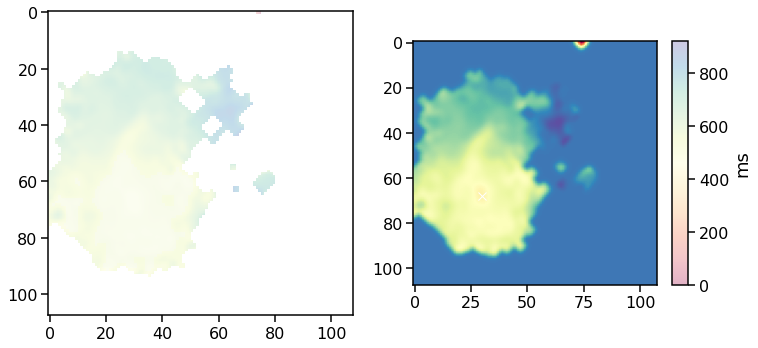

In [479]:
fig1, axes = plt.subplots(1,2, figsize=(12,6))
axes = axes.ravel()
im = axes[0].imshow(hm_nan, alpha=0.3)
axes[0].imshow(np.ma.masked_array(focus_mask, ~focus_mask), alpha=0.3, cmap="Blues")
plt.colorbar(im, label="ms", aspect=15, shrink=0.75)
#         freq = n_peaks_by_embryo[e][mask_idx]/30
axes[1].imshow(hm_time_smoothed)
#         im = axes.contour(np.flipud(hm_time)*1000)
axes[1].plot(min_index[1], min_index[0], "wx")

### Draw mask targeting initiation site

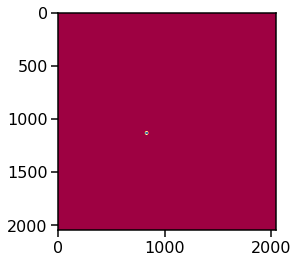

In [480]:
nrows = 2048
ncols = 2048
radius = 15

target_mask = np.zeros((nrows, ncols), dtype=bool)
offset = [(nrows - hm_time_smoothed.shape[0]*scale_factor)//2, \
          (ncols - hm_time_smoothed.shape[1]*scale_factor)//2]
rr, cc = draw.disk((offset[0] + min_index[0]*scale_factor, offset[1] + min_index[1]*scale_factor), radius)
target_mask[rr,cc] = True

fig1, ax1 = plt.subplots(figsize=(4,4))
ax1.imshow(target_mask)

In [481]:
skio.imsave(os.path.join(rootdir, "analysis", filename, "%s_locus_target.tif" % filename), target_mask)
skio.imsave(os.path.join(rootdir, "Snaps", "%s_locus_target.tiff" % filename), target_mask)

C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\2745475218.py:1: UserWarning: F:/Bill Jia/Optopatch/20220306/analysis\134239gtacr_E7_endogenous_50Hz\134239gtacr_E7_endogenous_50Hz_locus_target.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skio.imsave(os.path.join(rootdir, "analysis", filename, "%s_locus_target.tif" % filename), target_mask)
C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\2745475218.py:1: UserWarning: F:/Bill Jia/Optopatch/20220306/analysis\134239gtacr_E7_endogenous_50Hz\134239gtacr_E7_endogenous_50Hz_locus_target.tif is a low contrast image
  skio.imsave(os.path.join(rootdir, "analysis", filename, "%s_locus_target.tif" % filename), target_mask)
C:\Users\labmember\AppData\Local\Temp\ipykernel_50504\2745475218.py:2: UserWarning: F:/Bill Jia/Optopatch/20220306/Snaps\134239gtacr_E7_endogenous_50Hz_locus_target.tiff is a boolean image: setting True to 255 and False to 0. To sil